<a href="https://colab.research.google.com/github/RitvikPrabhu/Machine-Learning/blob/master/Neural_Networks_function_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#custom cmap
mymap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

params = {'legend.fontsize': 20,
          'figure.figsize': (15,10),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25*0.75,
          'ytick.labelsize': 25*0.75,
          'legend.title_fontsize': 25,
          'axes.titlepad': 25}
plt.rcParams.update(params)

import numpy as np
from scipy.stats import truncnorm

# Progress bar for long runs
#from tqdm.notebook import tqdm    # Use this if running the jupyter notebook directly
from tqdm import tqdm       # Use this if running in binder or colab

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# fix random seed for reproducibility
np.random.seed(0)

import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from IPython.display import clear_output

In [0]:
class Network:
    def __init__(self, input_size, output_size=1, hidden_layers=1, neurons=1,
                 init_method='normal', activation='sigmoid'):
        '''
        Initializes the Network Class.
        Returns nothing.
        - input_size is a positive integer, this is the number of features, not to be confused with input.size
        - output_size is a positive integer
        - hidden_layers is a positive integer
        - neurons is a positive integer
        - init_method is a string referrring to the parameter initialization
            possible options are: zeros, ones, random, normal, truncated_normal, Xavier, He
        - activation is a string referrring to the activation function
            possible options are: sigmoid, tanh, reLU, leaky-reLU, (softmax)
        '''
        self.input_size = input_size
        self.output_size = output_size
        self.layers = hidden_layers
        self.neurons = neurons
        self.init_method = init_method
        self.activation = activation
        
        self.layer_sizes = [input_size]
        for n in range(hidden_layers):
            self.layer_sizes.append(neurons)    # This assumes each hidden layer has the same number of neurons
        self.layer_sizes.append(output_size)
        

        # Weights and biases are kept in the self.params dictionary.
        self.params = {}
        np.random.seed(0)
        
##------------------------------------------------------
##  Parameter Initialization
##------------------------------------------------------
        for layer in range(1, len(self.layer_sizes)):
            if init_method.lower() == 'ones':
                self.params["W"+str(layer)] = np.ones((self.layer_sizes[layer], self.layer_sizes[layer-1]))
                self.params["B"+str(layer)] = np.ones((self.layer_sizes[layer], 1))
            elif init_method.lower() == 'zeros':
                self.params["W"+str(layer)] = np.zeros((self.layer_sizes[layer], self.layer_sizes[layer-1], ))
                self.params["B"+str(layer)] = np.zeros((self.layer_sizes[layer], 1))
            elif init_method.lower() == 'random':
                self.params["W"+str(layer)] = np.random.rand(self.layer_sizes[layer], self.layer_sizes[layer-1])
                self.params["B"+str(layer)] = np.random.rand(self.layer_sizes[layer], 1)
            elif init_method.lower() == 'normal':
                self.params["W"+str(layer)] = np.random.randn(self.layer_sizes[layer], self.layer_sizes[layer-1])
                self.params["B"+str(layer)] = np.random.randn(self.layer_sizes[layer], 1)
            elif init_method.lower() == 'truncated_normal':
                rad = 1 / np.sqrt(self.layer_sizes[layer-1])
                X = truncated_normal(2, 1, -rad, rad)
                self.params["W"+str(layer)] = X.rvs((self.layer_sizes[layer], self.layer_sizes[layer-1]))
                self.params["B"+str(layer)] = X.rvs((self.layer_sizes[layer], 1))
            elif init_method.lower()== 'xavier':
                self.params["W"+str(layer)] = np.random.randn(self.layer_sizes[layer], self.layer_sizes[layer-1]) * np.sqrt(1 / self.layer_sizes[layer-1])
                self.params["B"+str(layer)] = np.random.randn(self.layer_sizes[layer], 1)
            elif init_method.lower() == 'he':
                self.params["W"+str(layer)] = np.random.randn(self.layer_sizes[layer], self.layer_sizes[layer-1]) * np.sqrt(2 / self.layer_sizes[layer-1])
                self.params["B"+str(layer)] = np.random.randn(self.layer_sizes[layer], 1)
            elif init_method.lower() == 'test':
                self.params["W"+str(layer)] = np.ones((self.layer_sizes[layer], self.layer_sizes[layer-1]))
                self.params["B"+str(layer)] = np.zeros((self.layer_sizes[layer], 1))
            else:
                print(f"Initialization method \'{init_method}\' is not recognized")
                raise SystemExit
        

        
##------------------------------------------------------
##  Activation forward and backward
##------------------------------------------------------
    def forward_activation(self, x):
        '''
        Defines the activation functions
        Returns post activation neuron values.
        - x is a vector of arbitrary size
        '''
        if self.activation.lower() == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation.lower() == 'tanh':
            return np.tanh(x)
        elif self.activation.lower() == 'relu':
            return np.maximum(0, x)
        elif self.activation.lower() == 'leaky_relu':
            self.leaky_slope = 0.001
            return np.maximum(self.leaky_slope * x, x)
        else:
            print(f"Activation method \'{self.activation}\' is not recognized")
            raise SystemExit
    
    def backward_activation(self, x):
        '''
        Defines the derivative of the activation functions
        Returns pre activation neuron gradients.
        - x is a vector of arbitrary size
        '''
        if self.activation.lower() == 'sigmoid':
            f = 1 / (1 + np.exp(-x))
            return f * (1 - f)
        elif self.activation.lower() == 'tanh':
            return 1 / np.cosh(x)**2
        elif self.activation.lower() == 'relu':
            d = np.ones_like(x)
            d[x < 0] = 0
            return d
        elif self.activation.lower() == 'leaky_relu':
            d = np.ones_like(x)
            d[x < 0] = self.leaky_slope
            return d
        
##------------------------------------------------------
##  Feedforward
##    The input is propagated through the network with the current weights
##------------------------------------------------------
    # Uses previous neuron values (input) to compute the values in the next layer (output)
    # We store the neuron values pre- and post-activation to be used in the gradient backpropagation
    def feedforward(self, input):
        '''
        Performs a forward pass of the network with the current weights and biases
        Returns the output layer
        - input is an array of dimension input_size and of arbitrary size
        '''
        
    # Check input types
        # Check whether input is a list, transform to numpy array
        if isinstance(input, list):
            input = np.asarray(input)
        # Do the same if input is a single float
        elif isinstance(input, np.float64) or isinstance(input, np.float32) or isinstance(input, float):
            input = np.asarray(input).reshape(1)
        # Repeat for integers
        elif isinstance(input, np.int64) or isinstance(input, np.int32) or isinstance(input, int):
            input = np.asarray(input).reshape(1)
        elif isinstance(input, np.ndarray):
            pass
        else:
            print(f"Function feedforward received an unexpected data type, nominal behavior cannot be guaranteed.\n")

    # Check input shape
        # let features be the number of input neurons for the network aka input_size
        # and data_size be the numer of data points to pass through the network at once
        # The input data needs to contain input_size x data_size in some way
        if not input.size % self.input_size == 0:
            print(f"The input data isn't compatible with the network's input layer")
            raise SystemExit
        # The feedforward section was written expecting input data of shape (features, data_points)
        if len(input.shape) == 1:
            input = input.reshape(self.input_size, -1, order='F')
        elif len(input.shape) == 2:
            if input.shape == (self.input_size, input.size/self.input_size):
                pass
            elif input.shape == (input.size/self.input_size, self.input_size):
                input = input.T
            elif input.shape[0] == 1 or input.shape[1] == 1:
                input = input.reshape(self.input_size, -1, order='F')
            else:
                # Check if one of the dimensions is not divisible by features
                print(f"It's not immediately obvious how the input data is strucured.")
                if input.shape[0] % self.input_size != 0:
                    print(f"Assuming data points are arranged row major.\n")
                    input = input.T
                    input = input.reshape(self.input_size, -1, order='F')
                elif input.shape[1] % self.input_size != 0:
                    print(f"Assuming data points are arranged column major.\n")
                    input = input.reshape(self.input_size, -1, order='F')
                else:
                    print(f"Assuming data points are arranged column major.\n")
                    input = input.reshape(self.input_size, -1, order='F')
        else:
            print(f"It's not immediately obvious how the input data is strucured.")
            print(f"Assuming data points are arranged column major.\n")
            input = input.reshape(self.input_size, -1, order='F')
        
        # Initialize cache for neuron values (needed for the error backpropagation step)
        # We store values both before and after activation (not technically necessary)
        self.cache = {}
        self.cache["A"+str(0)] = input 
        for layer in range(1, len(self.layer_sizes)):
            weights = self.params["W"+str(layer)]
            bias = self.params["B"+str(layer)]
            
            # compute the neuron values pre-activation
            H = np.dot(weights, input) + bias
            self.cache["H"+str(layer)] = H
            
            # compute the activated values
            A = self.forward_activation(H)
            self.cache["A"+str(layer)] = A
            
            # output becomes input for next layer
            input = A
        # This is the final layer aka output
        output = A
        return output

##------------------------------------------------------
##  Network performance with current parameters
##------------------------------------------------------    
    def loss(self, y_true, y_pred):
        '''
        Computes the loss metric of the network by comparing predicted and true values on the the training set
        Returns the L2 Norm loss of the network for 1 data point
        - y_true/y_pred is an array of dimension ouput_size and of arbitrary size
        '''
        y_pred = y_pred.reshape(y_true.shape)
        return ((y_true - y_pred)**2).mean()

##------------------------------------------------------
##  Gradient Backpropagation
##    The loss gradient is propagated backwards through the whole network, using the chain rule
##------------------------------------------------------     
    # Computes the loss between prediction and true training output, then propagates the gradient backwards
    def backprop(self, y_true, y_pred, learning_rate):
        '''
        Performs a backward pass of the network with the current weights and biases, and updates them given the loss and learning rate
        Returns nothing.
        - y_true/y_pred is an array of dimension ouput_size and of arbitrary size
        - learning_rate is a float
        '''
        # loss derivative (this formula is specific to the L2 Norm used)
        dL = -2 * (y_true - y_pred)    # (out x 1)
        for layer in range(len(self.layer_sizes)-1,0,-1):
            
            # Compute the the activation gradient for the current layer
            H = self.cache["H"+str(layer)]      # this is a pre-activation value     (n(i-1) x 1)
            dA = self.backward_activation(H)    # (n(i-1) x 1)
            
            # Update loss gradient thus far through the activation (Hadamard product)
            dL = dL * dA
            
            # Compute dHdW(i) = A(i-1)
            dHdW = self.cache["A"+str(layer-1)]    # this is a post-activation value    (n(i-1) x 1)
            # Note that the matrix dHdW technically has the same dimensions as the weight matrix for the layer.
            #  However, each row of dHdW is identical and correspond to the A vectors from the previous layers, transposed.
            #  It's much more efficient to use an outer prodcut with the A vectors rather than creating the whole dHdW matrix.
            
            # Compute parameter updates for that layer
            dw_temp = []
            for k in range(dL.shape[1]):
                dw_temp.append(np.outer(dL[:, k:k+1], dHdW[:, k:k+1]))
            if self.batch_gradient.lower() == 'sum':
                dw = -learning_rate * sum(dw_temp)
                db = -learning_rate * np.sum(dL, axis=1).reshape(self.params["B"+str(layer)].shape)
            elif self.batch_gradient.lower() == 'mean':
                dw = -learning_rate * sum(dw_temp)/len(dw_temp)
                db = -learning_rate * np.mean(dL, axis=1).reshape(self.params["B"+str(layer)].shape)
            
            # Update loss gradient through the next layer
            weights = self.params["W"+str(layer)]
            dL = np.dot(weights.T, dL)
    
            
            # update weights and biases
            self.params["W"+str(layer)] += dw
            self.params["B"+str(layer)] += db
        pass
    
##------------------------------------------------------
##  Training
##    Using input data and known output, the parameters are iteratively optimized to minimize the global loss
##------------------------------------------------------      
    def train(self, input_data, output_data, epochs=400,
              learning_rate=0.1, batch_size=1, batch_gradient='Sum',
              progress=True, display_loss=False, plot_loss=False):
        '''
        Performs a forward pass, computes loss, computes gradients of loss vs weights and biases
        Returns a list of losses for the whole dataset.
        - input_data is an array of input_size dimension and arbitrary size
        - input_data is an array of output_size dimension and same length as input_data
        - epochs is a positive integer
        - learning_rate is a float (not enforced to be positive but it really should be)
        - batch_gradient is a boolean, it controls if the weights and biases are updated for every data point of for every epoch
        - progress is a boolean (controls whether the progress bar stays active once complete)
        - display_loss is a boolean (controls printing loss every 10 epochs)
        - plot_loss is a boolean (controls plotting loss vs epoch)
        '''
        self.batch_gradient = batch_gradient
        if self.batch_gradient.lower() != 'sum' and self.batch_gradient.lower() != 'mean':
            self.batch_gradient = 'sum'
        self.batch_size = batch_size
        
    # Check input/output types
        # Check whether input is a list, transform to numpy array
        if isinstance(input_data, list):
            input_data = np.asarray(input_data)
            output_data = np.asarray(output_data)
        # Do the same if input is a single float
        elif isinstance(input_data, np.float64) or isinstance(input_data, np.float32) or isinstance(input_data, float):
            input_data = np.asarray(input_data).reshape(1)
            output_data = np.asarray(output_data).reshape(1)
        # Repeat for integers
        elif isinstance(input_data, np.int64) or isinstance(input_data, np.int32) or isinstance(input_data, int):
            input_data = np.asarray(input_data).reshape(1)
            output_data = np.asarray(output_data).reshape(1)
        elif isinstance(input_data, np.ndarray):
            pass
        else:
            print(f"Function feedforward received an unexpected data type, nominal behavior cannot be guaranteed.\n")
    
    # Check output shape
        if len(input_data.shape) != len(output_data.shape):
            output_data = output_data.reshape(output_data.size, 1)
    
    # Check input shape
    # input_data is expected to be of shape (features, data points)
        
        # Check if number of elements is divisible by the number of input neurons
        if not input_data.size % self.input_size == 0:
            print(f"The input data isn't compatible with the network's input layer")
            raise SystemExit
            
        # If input is vector, reshape it to (features, ...)
        if len(input_data.shape) == 1:
            input_data = input_data.reshape(self.input_size, -1, order='F')
            output_data = output_data.reshape(self.output_size, -1, order='F')
        
        # If input is a matrix, reshape it to (features, ...)
        elif len(input_data.shape) == 2:
            if input_data.shape == (self.input_size, input_data.size/self.input_size):
            # Data is in the expected shape
                pass
            elif input_data.shape == (input_data.size/self.input_size, self.input_size):
            # Data is transposed
                input_data = input_data.T
                output_data = output_data.T
            elif input_data.shape[0] == 1 or input_data.shape[1] == 1:
            # Data is a 2D vector
                input_data = input_data.reshape(self.input_size, -1, order='F')
                output_data = output_data.reshape(self.output_size, -1, order='F')
            #else:
            #    # Check if one of the dimensions is not divisible by features
            #    print(f"It's not immediately obvious how the input data is strucured.")
            #    if input_data.shape[0] % self.input_size != 0:
            #        print(f"Assuming data points are arranged row major.\n")
            #        input_data = input_data.T
            #        input_data = input_data.reshape(self.input_size, -1, order='F')
            #    elif input_data.shape[1] % self.input_size != 0:
            #        print(f"Assuming data points are arranged column major.\n")
            #        input_data = input_data.reshape(self.input_size, -1, order='F')
            #    else:
            #        print(f"Assuming data points are arranged column major.\n")
            #        input_data = input_data.reshape(self.input_size, -1, order='F')
        #else:
        #    print(f"It's not immediately obvious how the input data is strucured.")
        #    print(f"Assuming data points are arranged column major.\n")
        #    input_data = input_data.reshape(self.input_size, -1, order='F')
        
        # Define description for progress bars
        if progress:
            print(f"Training the network on {len(output_data)} data points, for {epochs} epochs, with learning rate = {learning_rate}")
            description = f"Training"
        else:
            description = f"Training: {len(output_data)} pts"
        
        # Loop over epochs
        Losses = []
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", leave=progress, desc=description):
            # Loop over training data, in batches if necessary
            for k in range(0, input_data.shape[1], batch_size):
                input = input_data[:, k:k+batch_size]
                y_true = output_data[:, k:k+batch_size]
                y_pred = self.feedforward(input)
                self.backprop(y_true, y_pred, learning_rate)
            pass
            
            # Calculate total loss at the end of each epoch
            predictions = np.apply_along_axis(self.feedforward, 0, input_data)
            L = self.loss(output_data, predictions)
            Losses.append(L)
            if display_loss:
                if epoch % 10 == 9:
                    print(f"Epoch {epoch+1:d} loss: {L:.3f}")
                print()
        if plot_loss:
            plt.figure()
            plt.plot(Losses)
            plt.xlabel('Epochs')
            plt.ylabel('MSE Loss')
            plt.title('Learning curve')
            plt.show()
        return Losses

    
##------------------------------------------------------
##  Predict
##    The inputs are propagated through the network with the optimized weights
##------------------------------------------------------
    def predict(self, input_data):
        # Check data set shape
        if not isinstance(input_data, np.ndarray):
            print(f"The input data needs to be a numpy array")
            raise SystemExit
        elif len(input_data.shape) != 2:
            print(f"The input vector had unexpected format")
            raise SystemExit
        else:
            if input_data.shape[1] != self.input_size:
                input_data = input_data.reshape(input_data.shape[1], input_data.shape[0])
        
        output_data = np.zeros((input_data.shape[0], self.output_size))
        for i in range(input_data.shape[0]):
            input = input_data[i]
            output_data[i] = self.feedforward(input)
            
        return output_data
            
    
##------------------------------------------------------
##  Summary
##    Print some useful data about the network
##------------------------------------------------------      
    def summary(self):
        '''
        Prints the methods used for initialization, activation, and the number of parameters to be optimized.
        '''
        print(f"_________________________________________________________________")
        print(f"{'Layer':14s}{'Input Shape':19s}{'Output Shape':20s}{'Parameters #'}")
        print(f"=================================================================")
        
        total = 0
        for layer in range(1, self.layers+2):
            if layer == 1:
                input_shape = "("+str(self.input_size)+", 1)"
            else:
                input_shape = str(self.params["B"+str(layer-1)].shape)
            output_shape = str(self.params["B"+str(layer)].shape)
            parameters = self.params["W"+str(layer)].size + self.params["B"+str(layer)].size
            total += parameters
            if len(self.layer_sizes) < 7:
                print(f"{layer:<14d}{input_shape:19s}{output_shape:20s}{parameters:<d}")
                print(f"_________________________________________________________________")
        
        if not len(self.layer_sizes) < 7:
            print(f"...")
        print(f"=================================================================")
        print(f"Total Parameters: {total:,}")
        pass

    def draw(self, left=.1, right=.9, bottom=.1, top=.9):
        '''
        Draw a neural network cartoon using matplotilb.
        :parameters:
            - ax : matplotlib.axes.AxesSubplot
                The axes on which to plot the cartoon (get e.g. by plt.gca())
            - left : float
                The center of the leftmost node(s) will be placed here
            - right : float
                The center of the rightmost node(s) will be placed here
            - bottom : float
                The center of the bottommost node(s) will be placed here
            - top : float
                The center of the topmost node(s) will be placed here
            - layer_sizes : list of int
                List of layer sizes, including input and output dimensionality
        '''
        if len(self.layer_sizes) > 10 or self.neurons > 8:
            print(f"The network is too large to draw clearly")
            return
            
        # set up figure environment 
        fig = plt.figure(figsize=(12, 12))
        ax = fig.gca()
        ax.axis('off')
        
        layer_sizes = self.layer_sizes.copy()
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))
        h_spacing = (right - left)/float(len(layer_sizes) - 1)
        # Nodes
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
            for m in range(layer_size):
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                    color='w', ec='k', zorder=4)
                ax.add_artist(circle)
        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)
        plt.show()
        pass

In [0]:
N = 100
X = np.linspace(0,10,N)


input_data = X

output_data = np.sin(input_data)

network = Network(1,1,30,32, init_method='normal', activation='sigmoid')
network.train(input_data, output_data, epochs=1000, learning_rate=0.1, plot_loss=True)

Y_predict_temp=[]

for i in range(len(input_data)):
  Y_predict_temp.append(network.feedforward(input_data[i]))

Y_predict = np.asarray(Y_predict_temp).reshape(len(Y_predict_temp),1)

plt.plot(input_data,output_data)
plt.plot(input_data, Y_predict)
plt.show()



Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training the network on 1 data points, for 1000 epochs, with learning rate = 0.1



Training:   0%|          | 4/1000 [00:00<03:35,  4.62epoch/s]

KeyboardInterrupt: ignored

In [0]:
N = 1000
X = np.linspace(0, 10, N)
Y = np.sin(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
keras.backend.clear_session()
model = Sequential()
model.add(Dense(units = 64, activation='relu', input_dim = 1))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 7,969
Trainable params: 7,969
Non-trainable params: 0
____________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train Score: 1.66 RMSE
Test Score: 2.37 RMSE


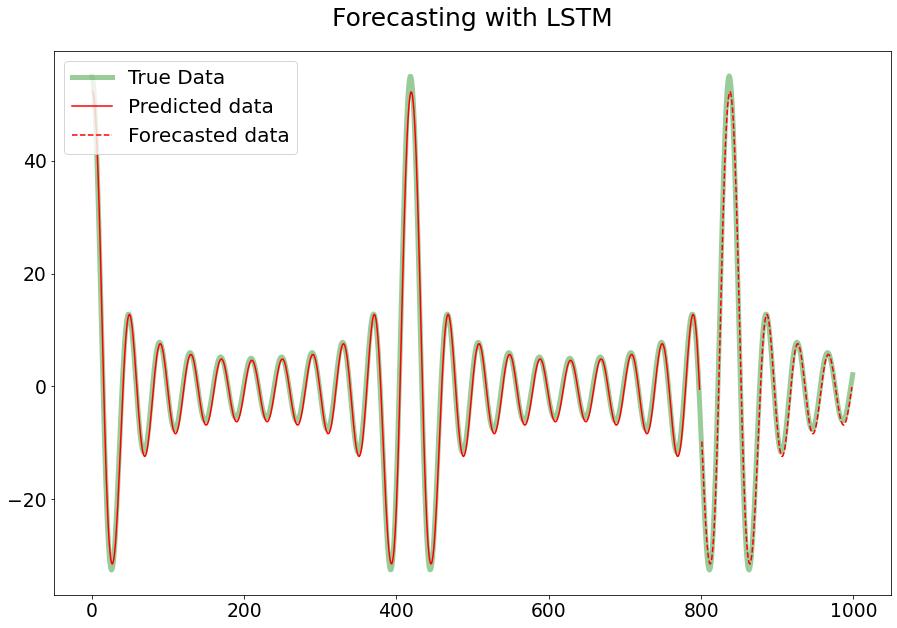

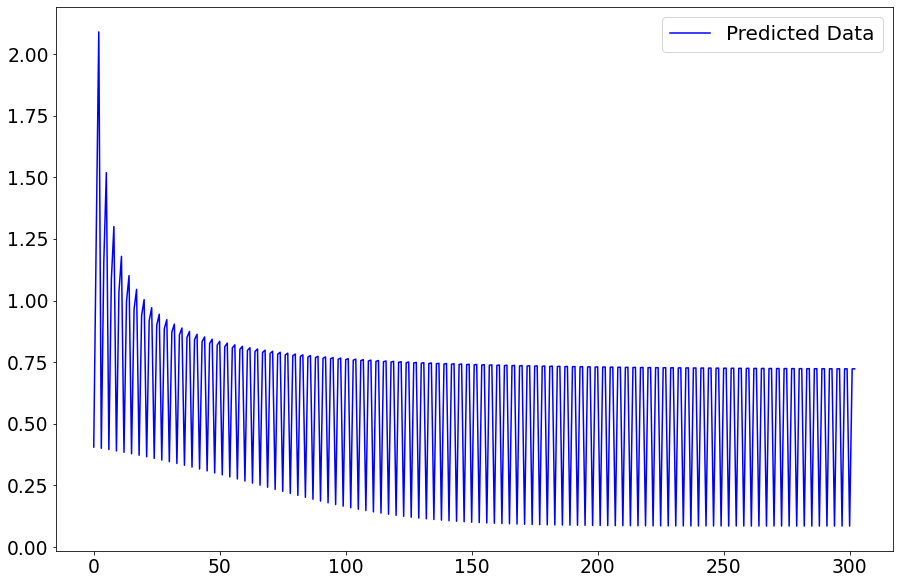

<Figure size 720x720 with 0 Axes>

In [31]:
N = 1000
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
X = np.linspace(0, 15, N)
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)


dataset = Y.reshape(Y.size, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * (0.8))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.title('Forecasting with LSTM')

plt.show()
#######################################################################################################################

#Prediction

def pred(N):  
  data = N + difference
  Y = 10*(np.cos(10*data)) + 9*(np.cos(9*data)) + 8*(np.cos(8*data)) + \
        7*(np.cos(7*data)) + 6*(np.cos(6*data)) + 5*(np.cos(5*data)) + 4*(np.cos(4*data)) +\
        3*(np.cos(3*data)) + 2*(np.cos(2*data)) + np.cos(data)
  global data_point 
  data_point = data
  return float(Y)
num_pred = 100
datalist = Y[-3:].copy()
#datalist = np.array(datalist) 
difference = X[3]-X[2]
data_point = X[-1]
x_label = []
for i in range(int(num_pred)):
  dataset = datalist.reshape(datalist.size, 1)
  #result = pred(data_point)
  result = model.predict(dataset[-3:].reshape(dataset[-3:].size,1,1))
  datalist = np.append(datalist, result)
  x_label.append(i)
res = [x + N for x in x_label]
plt.plot(datalist, label = 'Predicted Data', c = 'b')

plt.legend()
plt.figure(figsize=(10,10))

plt.show()



In [0]:
size = 8
def network(L, sequence_size, N):
  input_data = L
  Data = []
  for i in range(len(L)-sequence_size):
    q = 0
    w = []
    while q<sequence_size:
      w.append(L[i+q])
      q += 1
    Data.append(w)
    
  Target = []
  for i in range(sequence_size,len(L)):
    Target.append(L[i])

  data = np.array(Data, dtype=float)
  target = np.array(Target, dtype=float)
  data = data.reshape(data.shape[0], data.shape[1], 1)

  x_train = data
  y_train = target

  keras.backend.clear_session()
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(sequence_size, 1), return_sequences=True))
  model.add(LSTM(100, activation='relu', input_shape=(sequence_size, 1), return_sequences=True))
  model.add(LSTM(100, activation='relu', input_shape=(sequence_size, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True  )

  history = model.fit(x_train, y_train, epochs=6000, verbose=0, callbacks=[es], batch_size = 5)
  
  results = model.predict(x_train)
  w = 0
  while w < N:
    X = [[]]
    q = sequence_size
    while q > 0:
      X[0].append([L[-q]])
      q -= 1
    X = np.array(X)
    results = model.predict(X)
    L.append(float(results))
    w += 1
  print(L)
  plt.scatter(range(len(L)),L, label = "Sequencing of %d elements"%(sequence_size))
  plt.scatter(range(9),L[:9], color = 'black')
  plt.xticks([])
  plt.title("Sequence Prediction using LSTM")
  plt.legend()

Restoring model weights from the end of the best epoch
Epoch 00911: early stopping
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100.03765869140625, 110.16715240478516, 120.45172119140625, 130.95635986328125, 141.74542236328125, 152.88157653808594, 164.42523193359375, 176.43435668945312, 188.9644012451172, 202.06822204589844, 215.79600524902344, 230.19541931152344]
Restoring model weights from the end of the best epoch
Epoch 00463: early stopping
[10, 20, 30, 40, 50, 60, 70, 80, 90, 99.97239685058594, 110.16989135742188, 120.53509521484375, 131.3147430419922, 142.4945068359375, 154.30287170410156, 166.7667694091797, 180.10472106933594, 194.39096069335938, 209.84739685058594, 226.58746337890625, 244.84703063964844]
Restoring model weights from the end of the best epoch
Epoch 00174: early stopping
[10, 20, 30, 40, 50, 60, 70, 80, 90, 105.55316925048828, 119.99564361572266, 136.84156799316406, 159.641845703125, 183.60743713378906, 212.96397399902344, 250.48001098632812, 293.7983703613281, 347.7506

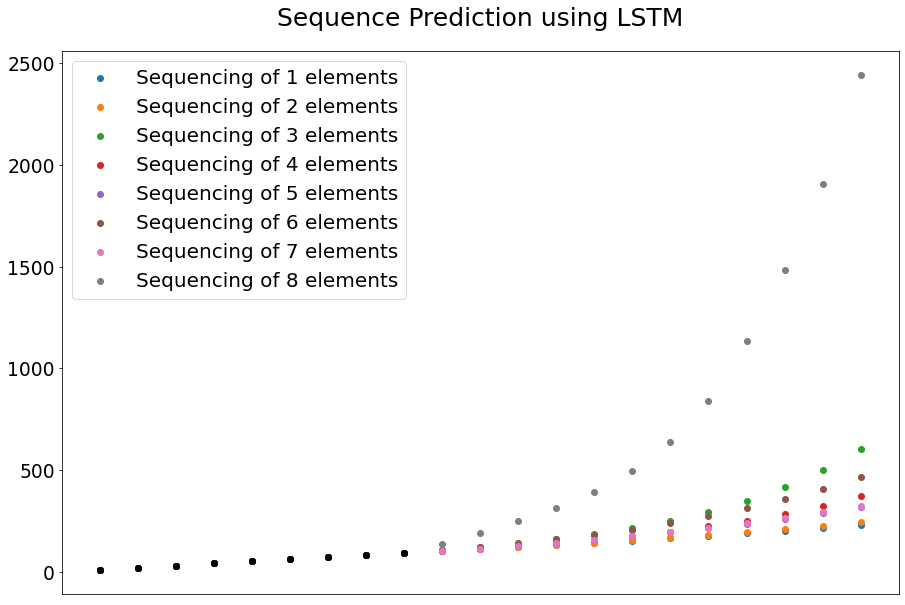

<Figure size 1440x1440 with 0 Axes>

In [0]:
for i in range(1,size+1):
  network([10, 20, 30, 40, 50, 60, 70, 80, 90], i, 12)

plt.figure(figsize=(20,20))
plt.show()